<a href="https://colab.research.google.com/github/giakomorssi/Deloitte_Project/blob/main/02_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import the Data

In [19]:
from google.colab import drive
drive.mount('/content/drive')

from sklearn.metrics import mean_squared_error

import pandas as pd

# Change Colab runtime to GPU
import os
os.environ['COLAB_TPU_ADDR'] = ''
os.environ['COLAB_GPU_ALLOC'] = '1'
os.environ['COLAB_GPU'] = '1'
print("Runtime switched to GPU")

import tensorflow as tf

if not tf.test.gpu_device_name():
    print('GPU device not found')
else:
    print('GPU device found:', tf.test.gpu_device_name())

# This code sets the runtime to use the GPU if available
if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")

pd.set_option('display.max_columns', None)

!pip install -q category_encoders

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Runtime switched to GPU
GPU device found: /device:GPU:0
Default GPU Device: /device:GPU:0


In [20]:
df = pd.read_csv('/content/drive/MyDrive/University/Deloitte/SupplyChainDataset.csv', encoding = 'latin-1')

# Cleaning the Data

In [21]:
# Remove Na and Empty Columns

df.drop(['Product Description', 'Order Zipcode', 'Order Profit Per Order', 'Customer Email', 'Customer Password', 'Customer Country', 'Customer Id', 'Customer Fname', 'Customer Lname', 'Customer Street', 'Order Country', 'Product Card Id', 'Product Category Id', 'Product Image', 'Customer State', 'shipping date (DateOrders)', 'order date (DateOrders)'], axis = 1, inplace = True) 
df.dropna(inplace = True) #remove 1 missing value

In [22]:
df.to_csv('/content/drive/MyDrive/University/Deloitte/df_lr.csv', index = False)

## Encoding

### Label Encoding

In [23]:
from sklearn.model_selection import train_test_split

X = df.drop(['Days for shipping (real)', 'Product Name'], axis = 1)
y = df['Days for shipping (real)']

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [25]:
import pandas as pd
from category_encoders import LeaveOneOutEncoder

# initialize the encoder
enc = LeaveOneOutEncoder(cols=['Customer City', 'Order City', 'Order State', 'Order Region'])

# fit and transform the entire dataset
X_train = enc.fit_transform(X_train, y_train)
X_test = enc.transform(X_test)

In [26]:
from sklearn.preprocessing import OneHotEncoder

# Select columns for one-hot encoding
one_hot_cols = [0, 7, 9, 12, 15, 30]
# Type, Department Name, Category Name, Market, Order Status, Customer Segment

# Fit one-hot encoder to training data
one_hot_encoder = OneHotEncoder(handle_unknown="ignore")

# Apply one-hot encoder to training and test data
X_train_one_hot = one_hot_encoder.fit_transform(X_train.iloc[:, one_hot_cols])
X_test_one_hot = one_hot_encoder.transform(X_test.iloc[:, one_hot_cols])

# Remove original columns from training and test data
X_train = X_train.drop(X_train.columns[one_hot_cols], axis=1)
X_test = X_test.drop(X_test.columns[one_hot_cols], axis=1)

# Concatenate one-hot encoded columns with remaining data
X_train = pd.concat([pd.DataFrame(X_train_one_hot.toarray()), X_train.reset_index(drop=True)], axis=1)
X_test = pd.concat([pd.DataFrame(X_test_one_hot.toarray()), X_test.reset_index(drop=True)], axis=1)

In [27]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

# Shipping Mode
custom_order = ['Same Day', 'First Class', 'Second Class', 'Standard Class']
le.fit(custom_order)
X_train['Shipping Mode'] = le.fit_transform(X_train['Shipping Mode'])
X_test['Shipping Mode'] = le.transform(X_test['Shipping Mode'])

# Delivery Status
# Define the custom order
custom_order = ['Shipping on time', 'Advance shipping', 'Late delivery', 'Shipping canceled']
le.fit(custom_order)
X_train['Delivery Status'] = le.fit_transform(X_train['Delivery Status'])
X_test['Delivery Status'] = le.transform(X_test['Delivery Status'])

## Scale the Data

In [28]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train.iloc[:, 82:] = scaler.fit_transform(X_train.iloc[:, 82:])
X_test.iloc[:, 82:] = scaler.transform(X_test.iloc[:, 82:])

<ipython-input-28-6700864cfc85>:5: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  X_train.iloc[:, 82:] = scaler.fit_transform(X_train.iloc[:, 82:])
<ipython-input-28-6700864cfc85>:6: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  X_test.iloc[:, 82:] = scaler.transform(X_test.iloc[:, 82:])


In [29]:
import pandas as pd
import numpy as np
import pickle

# Split the dataset into features and target
X_train = pd.DataFrame(X_train)
X_test = pd.DataFrame(X_test)
y_train = pd.DataFrame(y_train)
y_train = np.ravel(y_train)

X_train.columns = X_train.columns.astype(str)
X_test.columns = X_test.columns.astype(str)

# Prediction

## Choosing the Model

In [ ]:
from sklearn.ensemble import RandomForestRegressor
import pickle
from sklearn.metrics import mean_squared_error

model = RandomForestRegressor(n_estimators=100, max_depth=None)

# Fit the model
model.fit(X_train, y_train)

with open('/content/drive/MyDrive/University/Deloitte/models_lr/rf.pkl', 'wb') as file:
    pickle.dump(model, file)

mean_squared_error(y_test, model.predict(X_test), squared=False)

Epoch 1/100
2257/2257 - 14s - loss: 1.0233 - mean_squared_error: 0.4961 - val_loss: 0.5201 - val_mean_squared_error: 0.4008 - 14s/epoch - 6ms/step
Epoch 2/100
2257/2257 - 10s - loss: 0.4768 - mean_squared_error: 0.3879 - val_loss: 0.4497 - val_mean_squared_error: 0.3778 - 10s/epoch - 4ms/step
Epoch 3/100
2257/2257 - 10s - loss: 0.4485 - mean_squared_error: 0.3840 - val_loss: 0.4237 - val_mean_squared_error: 0.3644 - 10s/epoch - 4ms/step
Epoch 4/100
2257/2257 - 9s - loss: 0.4359 - mean_squared_error: 0.3792 - val_loss: 0.4345 - val_mean_squared_error: 0.3804 - 9s/epoch - 4ms/step
Epoch 5/100
2257/2257 - 10s - loss: 0.4307 - mean_squared_error: 0.3774 - val_loss: 0.4279 - val_mean_squared_error: 0.3762 - 10s/epoch - 4ms/step
Epoch 6/100
2257/2257 - 10s - loss: 0.4252 - mean_squared_error: 0.3738 - val_loss: 0.4408 - val_mean_squared_error: 0.3905 - 10s/epoch - 4ms/step
Epoch 7/100
2257/2257 - 13s - loss: 0.4222 - mean_squared_error: 0.3722 - val_loss: 0.4134 - val_mean_squared_error: 0.3

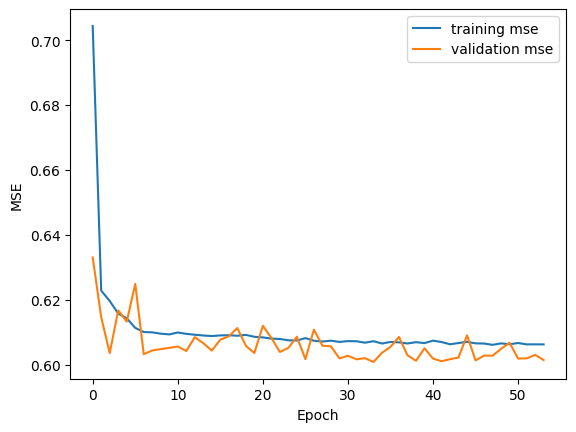

In [15]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras import regularizers
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np

# Define the neural network architecture
model = Sequential()
model.add(Dense(516, input_dim=X_train.shape[1], activation='relu', kernel_regularizer=regularizers.l2(0.005)))
model.add(Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.005)))
model.add(Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.005)))
model.add(Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.005)))
model.add(Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.005))) 
model.add(Dense(16, activation='relu', kernel_regularizer=regularizers.l2(0.005)))
model.add(Dense(1, activation='linear'))

# Compile the model with mean squared error loss function and Adam optimizer
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_squared_error'])

# Define the early stopping and model checkpoint callbacks
early_stopping = EarlyStopping(monitor='val_mean_squared_error', patience=20, verbose=2, mode='min')
model_checkpoint = ModelCheckpoint('/content/drive/MyDrive/University/Deloitte/models_lr/nn12 .h5', monitor='val_mean_squared_error', save_best_only=True, mode='min')

# Fit the model to the training data with early stopping and model checkpoint callbacks
history = model.fit(X_train, y_train, epochs=100, batch_size=64, validation_data=(X_test, y_test), verbose=2, callbacks=[early_stopping, model_checkpoint])

# Evaluate the model on the test data
loss, mse = model.evaluate(X_test, y_test, verbose=0)
print('Mean Squared Error on test set: {:.4f}'.format(mse))

# Plot the training and validation loss over epochs
import matplotlib.pyplot as plt
plt.plot(np.sqrt(history.history['mean_squared_error']), label='training mse')
plt.plot(np.sqrt(history.history['val_mean_squared_error']), label='validation mse')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend()
plt.show()

In [17]:
from keras.models import load_model
import numpy as np

model = load_model('/content/drive/MyDrive/University/Deloitte/models_lr/nn1.h5')

loss, mse = model.evaluate(X_test, y_test, verbose=0)

print(f'rMSE :{np.sqrt(mse)}, MSE: {mse}, Loss: {loss}')

rMSE :0.600909857508441, MSE: 0.3610926568508148, Loss: 0.39926594495773315


## try

In [2]:
def prediction_pkl(model_name = 'rf.pkl', threshold = 0.5):
  from google.colab import drive
  drive.mount('/content/drive')
  from sklearn.metrics import mean_squared_error
  import pandas as pd
  from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
  from sklearn.model_selection import train_test_split
  from sklearn.decomposition import PCA
  from sklearn.metrics import confusion_matrix, recall_score
  import os
  import pickle
  import pandas as pd
  import numpy as np
  from category_encoders import LeaveOneOutEncoder
  from keras.models import load_model
  from statsmodels.graphics.gofplots import qqplot
  from matplotlib import pyplot as plt
  import seaborn as sns

  within_threshold_mean = []
  mse_v = []
  loss_v = []

  df = pd.read_csv('/content/drive/MyDrive/University/Deloitte/df_lr.csv')
  X = df.drop(['Days for shipping (real)', 'Product Name'], axis = 1)
  y = df['Days for shipping (real)']

  with open(f'/content/drive/MyDrive/University/Deloitte/models_lr/{model_name}', 'rb') as f:
    model = pickle.load(f)
    
  print(f'\nModel: \n{model} \n')

  for i in range(1, 6):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)

    # initialize the encoder
    enc = LeaveOneOutEncoder(cols=['Customer City', 'Order City', 'Order State', 'Order Region'])

    # fit and transform the entire dataset
    X_train = enc.fit_transform(X_train, y_train)
    X_test = enc.transform(X_test)

    # fit and transform the entire dataset
    X_train = enc.fit_transform(X_train, y_train)
    X_test = enc.transform(X_test)

    # Select columns for one-hot encoding
    one_hot_cols = [0, 7, 9, 12, 15, 30]
    # Type, Department Name, Category Name, Market, Order Status, Customer Segment

    # Fit one-hot encoder to training data
    one_hot_encoder = OneHotEncoder(handle_unknown="ignore")

    # Apply one-hot encoder to training and test data
    X_train_one_hot = one_hot_encoder.fit_transform(X_train.iloc[:, one_hot_cols])
    X_test_one_hot = one_hot_encoder.transform(X_test.iloc[:, one_hot_cols])

    # Remove original columns from training and test data
    X_train = X_train.drop(X_train.columns[one_hot_cols], axis=1)
    X_test = X_test.drop(X_test.columns[one_hot_cols], axis=1)

    le = LabelEncoder()
    # Shipping Mode
    custom_order = ['Same Day', 'First Class', 'Second Class', 'Standard Class']
    le.fit(custom_order)
    X_train['Shipping Mode'] = le.fit_transform(X_train['Shipping Mode'])
    X_test['Shipping Mode'] = le.transform(X_test['Shipping Mode'])

    # Delivery Status
    # Define the custom order
    custom_order = ['Shipping on time', 'Advance shipping', 'Late delivery', 'Shipping canceled']
    le.fit(custom_order)
    X_train['Delivery Status'] = le.fit_transform(X_train['Delivery Status'])
    X_test['Delivery Status'] = le.transform(X_test['Delivery Status'])

    # Concatenate one-hot encoded columns with remaining data
    X_train = pd.concat([pd.DataFrame(X_train_one_hot.toarray()), X_train.reset_index(drop=True)], axis=1)
    X_test = pd.concat([pd.DataFrame(X_test_one_hot.toarray()), X_test.reset_index(drop=True)], axis=1)

    scaler = StandardScaler()

    X_train[X_train.columns[82:]] = scaler.fit_transform(X_train[X_train.columns[82:]])
    X_test[X_test.columns[82:]] = scaler.transform(X_test[X_test.columns[82:]])

    # Split the dataset into features and target
    X_train = pd.DataFrame(X_train)
    X_test = pd.DataFrame(X_test)
    y_train = pd.DataFrame(y_train)
    y_train = np.ravel(y_train)

    X_train.columns = X_train.columns.astype(str)
    X_test.columns = X_test.columns.astype(str)

    y_pred = model.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)

    # Calculate the percentage of predictions within the threshold value

    within_threshold_mean.append(sum(abs(y_pred.ravel() - y_test.ravel()) <= threshold) / len(y_pred))

  print(f'\n rMSE Mean: {np.mean(np.sqrt(mse))}')
  print(f'rMSE Std: {np.std(np.sqrt(mse))}')
  print(f'Within Threshold Mean: {np.mean(within_threshold_mean)}')
  print(f'Within Threshold Std: {np.std(within_threshold_mean)}\n')

  # Initialize a dictionary to store the squared errors and average predictions for each class
  mse_dict = {label: {'errors': [], 'preds': []} for label in np.unique(y_test)}

  # Calculate the squared error and average prediction for each instance and add them to the corresponding class lists
  for true_label, pred_label, error in zip(y_test, y_pred, (y_test - y_pred) ** 2):
      mse_dict[true_label]['errors'].append(error)
      mse_dict[true_label]['preds'].append(pred_label)

  # Calculate the mean squared error and average prediction for each class and print the results
  for label in mse_dict:
      instances = len(mse_dict[label]['errors'])
      if instances > 0:
          mse = np.mean(mse_dict[label]['errors'])
          rmse = np.sqrt(mse)
          avg_pred = np.mean(mse_dict[label]['preds'])
          print(f'Class {label}: {instances} instances, RMSE = {rmse:.6f}, Average Predicted Value = {avg_pred:.6f}')
      else:
          print(f'Class {label}: no instances in the test set')

  print('\n')
  
  residuals = y_test - y_pred

  # Distribution plot
  fig, ax = plt.subplots(figsize=(6, 4))
  sns.set_palette('colorblind')
  sns.set_style('darkgrid')
  sns.kdeplot(y_test, label='Actual', fill=True)
  sns.kdeplot(y_pred, label='Predicted', fill=True)
  plt.xlabel('Delivery time')
  plt.ylabel('Density')
  plt.title('Distribution Plot')
  plt.legend()
  plt.show()
  print('\n')

  # Plot a histogram of the residuals
  sns.set_style('darkgrid')
  fig, ax = plt.subplots(figsize=(6, 4))
  sns.histplot(residuals, bins=100, color='green', kde=True, ax=ax)
  ax.set_xlabel('Residuals')
  ax.set_ylabel('Frequency')
  ax.set_title('Histogram of Residuals')
  ax.set_xlim((-3, 3))
  sns.despine()
  plt.show()
  print('\n')

  # Plot the percentage of predictions within threshold days
  y_pred = model.predict(X_test)
  within_threshold = (np.abs(y_pred - y_test) < threshold).mean()
  outside_threshold = 1 - within_threshold
  fig, ax = plt.subplots()
  labels = ['Within threshold', 'Outside threshold']
  sizes = [within_threshold, outside_threshold]
  colors = ['#1f77b4', '#ff7f0e']
  plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
  plt.title('Percentage of Predictions Within Threshold', fontsize=13)
  plt.show()
  print('\n')

  # QQ plot
  residuals = y_test - y_pred
  qqplot(residuals, line='s')
  plt.title('QQ Plot of Residuals')
  plt.xlabel('Theoretical Quantiles')
  plt.ylabel('Sample Quantiles')
  plt.show()

In [1]:
def prediction_h5(model_name = 'nn1.h5', threshold = 0.5):
  from google.colab import drive
  drive.mount('/content/drive')
  from sklearn.metrics import mean_squared_error
  import pandas as pd
  from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
  from sklearn.model_selection import train_test_split
  from sklearn.decomposition import PCA
  from sklearn.metrics import confusion_matrix, recall_score
  import os
  import pickle
  import pandas as pd
  import numpy as np
  from category_encoders import LeaveOneOutEncoder
  from keras.models import load_model
  from matplotlib import pyplot as plt
  import seaborn as sns
  from statsmodels.graphics.gofplots import qqplot
  
  
  within_threshold_mean = []
  mse_v = []
  loss_v = []

  df = pd.read_csv('/content/drive/MyDrive/University/Deloitte/df_lr.csv')
  X = df.drop(['Days for shipping (real)', 'Product Name'], axis = 1)
  y = df['Days for shipping (real)']

  model = load_model(f'/content/drive/MyDrive/University/Deloitte/models_lr/{model_name}')

  print('\nModel: \n', model.summary(), '\n')
  for i in range(1, 6):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)

    # initialize the encoder
    enc = LeaveOneOutEncoder(cols=['Customer City', 'Order City', 'Order State', 'Order Region'])

    # fit and transform the entire dataset
    X_train = enc.fit_transform(X_train, y_train)
    X_test = enc.transform(X_test)

    # fit and transform the entire dataset
    X_train = enc.fit_transform(X_train, y_train)
    X_test = enc.transform(X_test)

    # Select columns for one-hot encoding
    one_hot_cols = [0, 7, 9, 12, 15, 30]
    # Type, Department Name, Category Name, Market, Order Status, Customer Segment

    # Fit one-hot encoder to training data
    one_hot_encoder = OneHotEncoder(handle_unknown="ignore")

    # Apply one-hot encoder to training and test data
    X_train_one_hot = one_hot_encoder.fit_transform(X_train.iloc[:, one_hot_cols])
    X_test_one_hot = one_hot_encoder.transform(X_test.iloc[:, one_hot_cols])

    # Remove original columns from training and test data
    X_train = X_train.drop(X_train.columns[one_hot_cols], axis=1)
    X_test = X_test.drop(X_test.columns[one_hot_cols], axis=1)

    le = LabelEncoder()
    # Shipping Mode
    custom_order = ['Same Day', 'First Class', 'Second Class', 'Standard Class']
    le.fit(custom_order)
    X_train['Shipping Mode'] = le.fit_transform(X_train['Shipping Mode'])
    X_test['Shipping Mode'] = le.transform(X_test['Shipping Mode'])

    # Delivery Status
    # Define the custom order
    custom_order = ['Shipping on time', 'Advance shipping', 'Late delivery', 'Shipping canceled']
    le.fit(custom_order)
    X_train['Delivery Status'] = le.fit_transform(X_train['Delivery Status'])
    X_test['Delivery Status'] = le.transform(X_test['Delivery Status'])

    # Concatenate one-hot encoded columns with remaining data
    X_train = pd.concat([pd.DataFrame(X_train_one_hot.toarray()), X_train.reset_index(drop=True)], axis=1)
    X_test = pd.concat([pd.DataFrame(X_test_one_hot.toarray()), X_test.reset_index(drop=True)], axis=1)

    scaler = StandardScaler()

    X_train[X_train.columns[82:]] = scaler.fit_transform(X_train[X_train.columns[82:]])
    X_test[X_test.columns[82:]] = scaler.transform(X_test[X_test.columns[82:]])

    # Split the dataset into features and target
    X_train = pd.DataFrame(X_train)
    X_test = pd.DataFrame(X_test)
    y_train = pd.DataFrame(y_train)
    y_train = np.ravel(y_train)

    X_train.columns = X_train.columns.astype(str)
    X_test.columns = X_test.columns.astype(str)

    loss, mse = model.evaluate(X_test, y_test, verbose=1)

    mse_v.append(mse)
    loss_v.append(loss)

    y_pred = model.predict(X_test, verbose=1)

    # Calculate the percentage of predictions within the threshold value

    within_threshold_mean.append(sum(abs(y_pred.ravel() - y_test.ravel()) <= threshold) / len(y_pred))

  print(f'\n rMSE Mean: {np.mean(np.sqrt(mse_v))}')
  print(f'rMSE Std: {np.std(np.sqrt(mse_v))}')
  print(f'Loss Mean: {np.mean(loss_v)}')
  print(f'Loss Std: {np.std(loss_v)}')
  print(f'Within Threshold Mean: {np.mean(within_threshold_mean)}')
  print(f'Within Threshold Std: {np.std(within_threshold_mean)}\n')

  # Initialize a dictionary to store the squared errors and average predictions for each class
  mse_dict = {label: {'errors': [], 'preds': []} for label in np.unique(y_test)}

  # Calculate the squared error and average prediction for each instance and add them to the corresponding class lists
  for true_label, pred_label, error in zip(y_test, y_pred, (y_test - y_pred) ** 2):
      mse_dict[true_label]['errors'].append(error)
      mse_dict[true_label]['preds'].append(pred_label)

  # Calculate the mean squared error and average prediction for each class and print the results
  for label in mse_dict:
      instances = len(mse_dict[label]['errors'])
      if instances > 0:
          mse = np.mean(mse_dict[label]['errors'])
          rmse = np.sqrt(mse)
          avg_pred = np.mean(mse_dict[label]['preds'])
          print(f'Class {label}: {instances} instances, RMSE = {rmse:.6f}, Average Predicted Value = {avg_pred:.6f}')
      else:
          print(f'Class {label}: no instances in the test set')

  # Distribution plot
  fig, ax = plt.subplots(figsize=(10, 6))
  sns.set_palette('colorblind')
  sns.set_style('darkgrid')
  sns.kdeplot(y_test.ravel(), label='Actual', fill=True)
  sns.kdeplot(y_pred.ravel(), label='Predicted', fill=True)
  plt.xlabel('Delivery time')
  plt.ylabel('Density')
  plt.title('Distribution Plot')
  plt.legend()
  plt.show()
  print('\n')

  # Plot a histogram of the residuals
  sns.set_style('darkgrid')
  fig, ax = plt.subplots(figsize=(10, 6))
  sns.histplot(residuals, bins=100, color='green', kde=True, ax=ax)
  ax.set_xlabel('Residuals')
  ax.set_ylabel('Frequency')
  ax.set_title('Histogram of Residuals')
  ax.set_xlim((-3, 3))
  sns.despine()
  plt.show()
  print('\n')

  # Plot the percentage of predictions within threshold days
  y_pred = model.predict(X_test)
  within_threshold = (np.abs(y_pred.ravel() - y_test.ravel()) < threshold).mean()
  outside_threshold = 1 - within_threshold
  fig, ax = plt.subplots()
  labels = ['Within threshold', 'Outside threshold']
  sizes = [within_threshold, outside_threshold]
  colors = ['#1f77b4', '#ff7f0e']
  plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
  plt.title('Percentage of Predictions Within Threshold', fontsize=13)
  plt.show()
  print('\n')

  # QQ plot
  from statsmodels.graphics.gofplots import qqplot
  qqplot(residuals, line='s')
  plt.title('QQ Plot of Residuals')
  plt.xlabel('Theoretical Quantiles')
  plt.ylabel('Sample Quantiles')
  plt.show()

In [ ]:
prediction_h5()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 516)               57276     
                                                                 
 dense_1 (Dense)             (None, 256)               132352    
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 dense_3 (Dense)             (None, 64)                8256      
                                                                 
 dense_4 (Dense)             (None, 32)                2080      
                                                                 
 dense_5 (Dense)             (None, 16)                528 

In [1]:
import numpy as np
from sklearn.metrics import mean_squared_error
import pickle
from keras.models import load_model

# Load the model from file
model = load_model(f'/content/drive/MyDrive/University/Deloitte/models_lr/nn1.h5')

# Make predictions on the test set
y_pred = model.predict(X_test)

# Calculate the overall root mean squared error
rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f'Overall RMSE: {rmse:.6f}')

# Initialize a dictionary to store the squared errors and average predictions for each class
mse_dict = {label: {'errors': [], 'preds': []} for label in np.unique(y_test)}

# Calculate the squared error and average prediction for each instance and add them to the corresponding class lists
for true_label, pred_label, error in zip(y_test, y_pred, (y_test - y_pred) ** 2):
    mse_dict[true_label]['errors'].append(error)
    mse_dict[true_label]['preds'].append(pred_label)

# Calculate the mean squared error and average prediction for each class and print the results
for label in mse_dict:
    instances = len(mse_dict[label]['errors'])
    if instances > 0:
        mse = np.mean(mse_dict[label]['errors'])
        rmse = np.sqrt(mse)
        avg_pred = np.mean(mse_dict[label]['preds'])
        print(f'Class {label}: {instances} instances, RMSE = {rmse:.6f}, Average Predicted Value = {avg_pred:.6f}')
    else:
        print(f'Class {label}: no instances in the test set')


Exception ignored in: <function _xla_gc_callback at 0x7fcf580e8670>
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/jax/_src/lib/__init__.py", line 97, in _xla_gc_callback
    def _xla_gc_callback(*args):
KeyboardInterrupt: 


NameError: ignored

In [ ]:
!rm -r Deloitte_Project
!git clone https://github.com/giakomorssi/Deloitte_Project
!pip install -q category_encoders
import sys
sys.path.append('/content/Deloitte_Project')
from functions import prediction_h5
from functions import prediction_pkl

prediction_h5('nn1.h5')

## Feature Importance

In [ ]:
# Top 10 Feature Importances
from sklearn.inspection import permutation_importance
from matplotlib import pyplot as plt
import seaborn as sns


fig, ax = plt.subplots(figsize=(10, 6))
importances = model.feature_importances_
sorted_idx = importances.argsort()[::-1]
sns.set_style('darkgrid')
top_features = X.columns[sorted_idx][:10]
top_importances = importances[sorted_idx][:10]
fig, ax = plt.subplots(figsize=(8, 4))
sns.barplot(x=top_features, y=top_importances, ax=ax, color='steelblue')
ax.set_xlabel('Feature', fontsize=14)
ax.set_xticklabels(top_features, rotation=90, ha='right', fontsize=10)
ax.set_ylabel('Importance Score', fontsize=14)
ax.tick_params(axis='y', labelsize=12)
ax.set_title('Top 10 Feature Importances', fontsize=16)
sns.despine()
plt.show()
print('\n')